In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pystorms
import pandas as pd

In [4]:
env = pystorms.gamma()
done = False
while not done:
    done = env.step(np.ones(11))
data = env.data_log

In [6]:
flows = pd.DataFrame.from_dict(data["flow"])
flooding = pd.DataFrame.from_dict(data["flooding"])

By default, ```env.data_log``` does not log depths. It only logs, 

In [10]:
env.data_log.keys()

dict_keys(['performance_measure', 'flow', 'flooding'])

So, if we want to log depths, we can just add the metric to the logger. Here is how one would go about doing it.

In [11]:
env = pystorms.gamma()
done = False 

env.data_log["depthN"] = {}
nodes = np.linspace(1,11,11, dtype=int)

for i in nodes:
    env.data_log["depthN"][str(i)] = []
while not done:
    done = env.step(np.ones(11))
data = env.data_log

In [13]:
data.keys()

dict_keys(['performance_measure', 'flow', 'flooding', 'depthN'])

There you go, now you can log depths. This can be extended to log anything that is computed in swmm. More on this later. 

In [14]:
depths = pd.DataFrame.from_dict(data["depthN"])

Text(0.5, 0, 'Simulation Time')

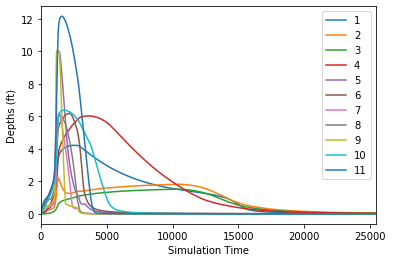

In [18]:
ax = depths.plot()
ax.set_ylabel("Depths (ft)")
ax.set_xlabel("Simulation Time")

Now, lets write a objective function for bayesian optimization

In [36]:
def objective_function(x):
    env = pystorms.scenarios.gamma()
    done = False

    valves = np.ones(11)
    for i in range(0, 4):
        valves[0] = x[0][i]

    env.data_log["depthN"] = {}
    nodes = np.linspace(1,11,11, dtype=int)
    for i in nodes:
        env.data_log["depthN"][str(i)] = []
        
    while not done:
        done = env.step(valves)
        
    depths = pd.DataFrame.from_dict(data["depthN"])
    flows = pd.DataFrame.from_dict(data["flow"])
    flooding = pd.DataFrame.from_dict(data["flooding"])
    
    loss = 0.0
    
    # drop all the flows, depths and flooding from upstream nodes 
    for i in nodes[4:]:
        del depths[str(i)]
        del flows["O"+str(i)]
        del flooding[str(i)]
        
    # Check if there is flooding in the assets
    flooding = flooding.gt(0.0)
    flooding = flooding.any()
    if flooding.any():
        loss += np.inf

    # Check if flows are exceeding threshold
    flows = flows.sub(4.0)
    flows[flows < 0.0] = 0.0
    loss += flows.sum(axis=1).sum(axis=0)

    # go though all the depths 
    for i in depths.keys():
        if depths[i].values[-1] > 0.10:
            loss += depths[i].values[-1] * 10000.0
        else:
            loss += 0.0

    return loss

In [37]:
x = np.array([[1.0, 1.0, 1.0, 1.0]])
loss = objective_function(x)

In [38]:
type(loss)

numpy.float64